In [1]:
%load_ext autoreload

This network simulator aims provide a platform for simulating distributed workflows over the WAN. While the simulator must simulate some features such as latency and capacity, it is not intended to model network protocols. In particular, layer 0-3 is highly abstracted and TCP model is simplistic. The focus is on the features and behavior of workflows competing for network resources.

Abstractions are Workflows, Packet, Router, Port, Link, Topology, Endpoint


Workflows
---------

Workflows are sender and receivers of packets over the network. They are responsible for simulating:

  . sending and receiving of data.
  
  . routing. This allow to support simulation of intelligent, dynamic, routing. 
  
  . congestion.
  
  . pacing.
  
  . maintaint statistics, including errors and losses.
  
  
Workflow implementations uses routers and ports to send and receive data. They also implement functions that routers and ports will come back when:

  . a packet is received on a port. This allows the workflow to change the path of the packet if it desires so (not implemented yet). When the last port of the path receives a packet, it delivers it to the workflow.
  
  . a packet is dropped anywhere in the path. This allows the workflow to simulate a particular flow control mechanism.

IMPORTANT: size and time units are not correctly calculated at the moment. This will be fixed soon.

Packet
------

Packets represent a quantity of data expressed as an integer. A packet maintains its own path as a ordered list of router/ports (note, this may/should be changed as a list of links).

Link
----

Links are undirectional, maintain connectivity between two ports, and simulate latency.

Note that timing of the simulation is currently wall clock. That means that latency is expressed in seconds which does not make sense. The overall timing of the simulator needs to allow finer grain timing.

Port
----

Ports are responsible for simulating:
  . ingress / egress of packets
  . capacity limit (i.e. drop packets)
  . buffer (not yet implemented)
  . layer 2 flow control (not yet implemented)

Router
------

Routers are made up ports that are interconnected with a full mesh of links with no latency. 

Endpoint
--------

Endpoints are special types of routers that are used as sources and destinations of workflows. In addition to having a port with a given capacity, the actual rate can statically or dynamically adjusted (rate limiting)


Topology
--------

The set of routers and links constitues the simulated topology which is represented as a graph.

Let's start with a simple topology made of two connected routers. 

Trying this out
--------------
Let's create a simple topology made of two routers.

The link has a capacity of 10 and no latency.

Note that the time scaling is defined when creating the topology

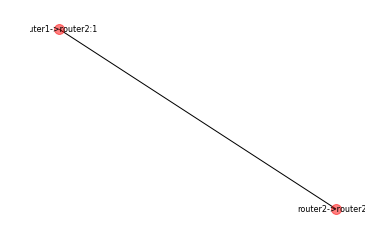

In [271]:
%aimport sim
%autoreload 2
from sim import Topology


topo = Topology("test topology", ticks_per_sec=100)

topo.add_routers(['router1','router2'])
topo.add_link(router_a='router1',router_b='router2',capacity=10000,latency=0) 

topo.draw()

This shows two ports (one in each router) inter connected. This network is not very useful until we add two endpoints, 'server1' and 'server2' respectively connected to router1 and router2:

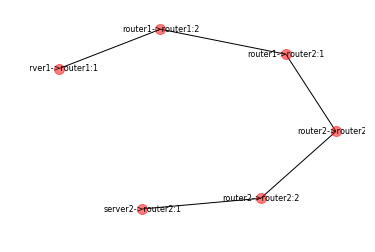

In [272]:
from sim import Endpoint

server1 = Endpoint(name='server1',topology=topo,capacity=10000,rate=8000)
server1.connect('router1')
server2 = Endpoint(name='server2',topology=topo,capacity=10000,rate=8000)
server2.connect('router2')

topo.draw()

Time now to create a workflow. A workflow implementation must extend sim.Workflow. A default implementation is provided by sim.DataTransfer simulating a file transfer. It simulates pacing and dynamic windows. 

In [273]:
from sim import DataTransfer

flow1 = DataTransfer(name="flow1",
                     src=server1,
                     dst=server2,
                     data_size=100000,
                     max_rate=8000,
                     topology=topo)

flow1.info = True
flow1.debug = False
                     
topo.schedule_workflow(workflow=flow1)

In [274]:
topo.start_simulation(until_sec=50)
#topo.start_simulation()

Simulation starts at  0 and will run until  5000.0
0 start file transfer flow1
1753 flow1 success 100045 packets 1754 drop 0   0 %
Simulation stops at 5000.0


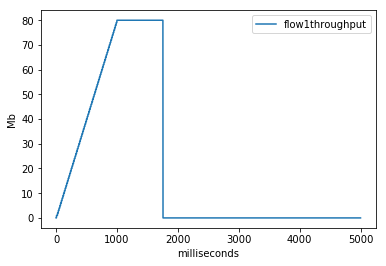

In [275]:
flow1.plot_receive()
topo.show_plots()

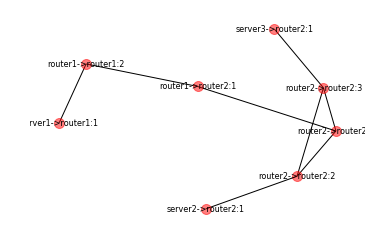

Simulation starts at  0 and will run until  10000.0
0 start file transfer flow1
0 start file transfer flow2
Simulation stops at 10000.0


In [313]:
%aimport sim
%autoreload 2
from sim import Topology

topo = Topology("test topology", ticks_per_sec=100)

from sim import Endpoint

topo.add_routers(['router1','router2'])
topo.add_link(router_a='router1',router_b='router2',capacity=10000,latency=100)

server1 = Endpoint(name='server1',topology=topo,capacity=10000,rate=8000)
server1.connect('router1', latency=20)
server2 = Endpoint(name='server2',topology=topo,capacity=10000,rate=8000)
server2.connect('router2', latency=20)
server3 = Endpoint(name='server3',topology=topo,capacity=10000,rate=8000)
server3.connect('router2', latency=10)

from sim import DataTransfer

flow1 = DataTransfer(name="flow1",
                     src=server1,
                     dst=server2,
                     data_size=1000000,
                     max_rate=8000,
                     topology=topo)

flow1.info = True
flow1.debug = False
                     
topo.schedule_workflow(workflow=flow1)

flow2 = DataTransfer(name="flow2",
                     src=server2,
                     dst=server3,
                     data_size=1000000,
                     max_rate=8000,
                     topology=topo)

flow2.info = True
flow2.debug = False
                     
topo.schedule_workflow(workflow=flow2)

topo.draw()

topo.start_simulation(until_sec=100)

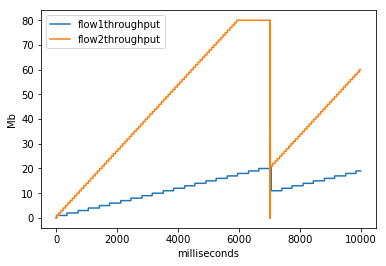

In [314]:
flow1.plot_receive()
flow2.plot_receive()
topo.show_plots()